# Etsy Exploratory Analysis

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import plotly.express as px

#geo stuff
import geoplot
import geopandas
import geopandas.tools
import geoplot.crs as gcrs


%matplotlib inline


In [3]:
df = pd.read_csv("datasets/shops_add.csv")
df.head()

seller_location  seller_join_date  number_of_sales  \
0            Jaipur, India              2018                0   
1                      NaN              2017              226   
2  Soorts-Hossegor, France              2017               14   
3                      NaN              2019                0   
4                      NaN              2019                0   

   number_of_reviews  average_review_score  number_of_items      seller_town  \
0                NaN                   NaN                2           Jaipur   
1               12.0                   5.0                3              NaN   
2                2.0                   4.0                0  Soorts-Hossegor   
3                NaN                   NaN                2              NaN   
4                NaN                   NaN                9              NaN   

  seller_country  
0          India  
1            NaN  
2         France  
3            NaN  
4            NaN

# Variable identification

Here we use 2 types of observation:
* continous
* categorical

and also [4 level of measurement](https://en.wikipedia.org/wiki/Level_of_measurement):
* nominal (not sortable)
* ordinal (sortable, but no degree of difference)
* interval (degree of difference, but not the ratio)
* ratio (our favourite! e.g. age, weight, salary)

So we have following variables in our dataset:
* seller_location - categorical, nominal
* seller_join_date - continous, interval
* **number_of_sales** (!) - continous, ratio
* number_of_reviews - continous, ratio
* average_review_score - continous, ratio
* number of items - contimous, ratio

As we also can see, ordinal level of measurement is not used, and ratio is presented quite well. 

So let's dig deeper!

# Univariative Analysis

In [4]:
df.describe()

seller_join_date  number_of_sales  number_of_reviews  \
count     414057.000000    414057.000000      343125.000000   
mean        2014.511036       546.841401         146.683783   
std            3.274972      3773.242918        1065.174816   
min         1969.000000         0.000000           1.000000   
25%         2012.000000         7.000000           4.000000   
50%         2015.000000        32.000000          13.000000   
75%         2017.000000       170.000000          57.000000   
max         2019.000000    539221.000000      184489.000000   

       average_review_score  number_of_items  
count         210095.000000    414057.000000  
mean               4.897582        45.343909  
std                0.385392       231.310836  
min                1.000000         0.000000  
25%                4.954200         0.000000  
50%                5.000000         6.000000  
75%                5.000000        31.000000  
max                5.000000     78611.000000

## seller_location


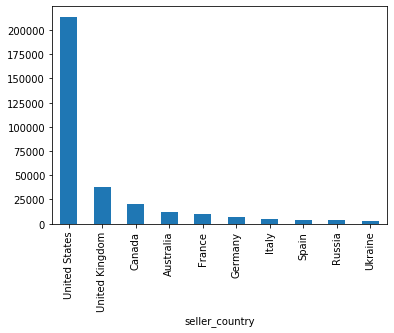

In [5]:
locations = df.copy()
locations.loc[(locations['seller_country'] == 'England'), 'seller_country'] = 'United Kingdom'
locations.loc[(locations['seller_country'] == 'Wales'), 'seller_country'] = 'United Kingdom'
locations.loc[(locations['seller_country'] == 'Scotland'), 'seller_country'] = 'United Kingdom'
locations.loc[(locations['seller_country'] == 'Northern Ireland'), 'seller_country'] = 'United Kingdom'

by_country = locations[['seller_country']].groupby(by='seller_country').size().sort_values(ascending=False).rename('number_of_shops')
by_country.head(n=10).plot.bar()

# set(df[ df['seller_town'].isna() & df['seller_country'].notna() ]['seller_country'])

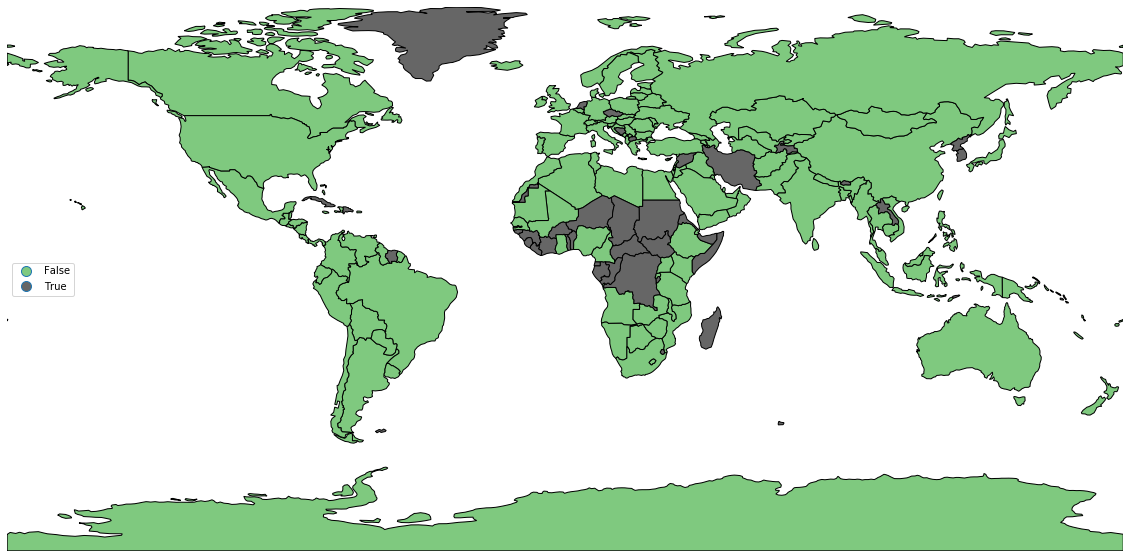

In [6]:
countries_geocodes = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))[['name','geometry', 'iso_a3']]
by_country_geo = countries_geocodes.set_index('name').join(by_country, how='left').reset_index()
by_country_geo['no_shops'] = by_country_geo['number_of_shops'].isna()
by_country_geo['number_of_shops_log'] = np.log(by_country_geo['number_of_shops'])
# https://residentmario.github.io/geoplot/plot_references/plot_reference.html#choropleth
geoplot.choropleth(by_country_geo, hue='no_shops', cmap='Accent', categorical=True, legend=True, figsize=(20, 10), )


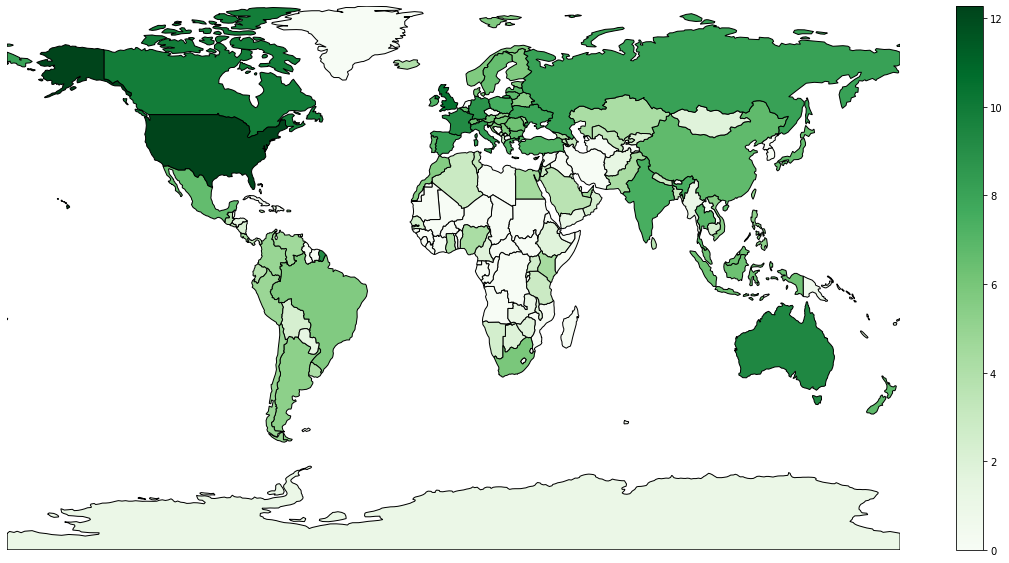

In [7]:
geoplot.choropleth(by_country_geo, hue='number_of_shops_log', cmap='Greens', k = None,legend=True, figsize=(20, 10))


### Interpreations for seller_location
* shops exist in almost all countires in the world
* United States is the leader by number of shops opened, and top 5 is: US, UK, Canada, Australia, France


## seller_join_date


In [7]:
by_join_date = df[['seller_join_date']].groupby(by='seller_join_date').size().rename('number_of_shops')
by_join_date

seller_join_date
1969        1
2005      431
2006     2483
2007     6647
2008    13209
2009    16551
2010    19440
2011    25802
2012    28294
2013    33069
2014    36617
2015    41416
2016    45969
2017    53723
2018    57801
2019    32604
Name: number_of_shops, dtype: int64

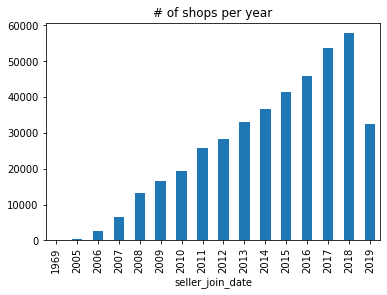

In [8]:
b = by_join_date.plot.bar(title='# of shops per year')

In [9]:
by_join_date_reg = by_join_date[(by_join_date.index > 2000) & (by_join_date.index < 2019)] 
lr = scipy.stats.linregress(by_join_date_reg.index, by_join_date_reg.values)
lr

LinregressResult(slope=4405.507692307692, intercept=-8834432.151648352, rvalue=0.9972511134842311, pvalue=6.192603608642316e-15, stderr=94.49211120842827)

In [10]:
by_join_date_reg_df = by_join_date_reg.to_frame()
by_join_date_reg_df['number_of_shops_pred'] = [ x*lr.slope + lr.intercept for x in by_join_date_reg.index ]

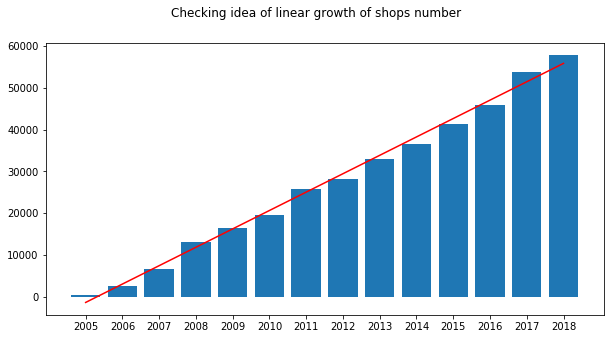

In [11]:
plt.figure(figsize=(10, 5))
plt.xticks(by_join_date_reg_df.index)
plt.bar(by_join_date_reg_df.index, by_join_date_reg_df['number_of_shops'].values)
plt.plot(by_join_date_reg_df.index, by_join_date_reg_df['number_of_shops_pred'].values, 'r-')
plt.suptitle("Checking idea of linear growth of shops number")
plt.show()

In [12]:
df[ df['seller_join_date'] == 1969]

seller_location  seller_join_date  number_of_sales  \
313051  Indiana, United States              1969                2   

        number_of_reviews  average_review_score  number_of_items seller_town  \
313051                NaN                   NaN                0     Indiana   

       seller_country  
313051  United States

In [13]:
#let's remove this outlier - it'll imrpove data
df = df [df['seller_join_date'] >= 2005]

### Interpreations for join_by_date
* there is 1 (!) shop https://www.etsy.com/shop/HorseShoe7 dated to be from 1969 - must be some interesting (possibly intentional) glitch :) 
* growth of number of shops is pretty much increasing every year, with significant grow in 2018
* 2019 is less than 2018, but as data has been scraped in the end of July 2019, it does not tell us about anything. Would be interesting to see latest data ;) 
* it looks like that data from 2005 to 2017 seems to follow linear regression, but data from 2018 beat it significantly. Exponential growth of shops number on Etsy? Maybe! Future will tell

## number_of_sales


In [14]:
df['number_of_sales'].describe()

count    414056.000000
mean        546.842717
std        3773.247379
min           0.000000
25%           7.000000
50%          32.000000
75%         170.000000
max      539221.000000
Name: number_of_sales, dtype: float64

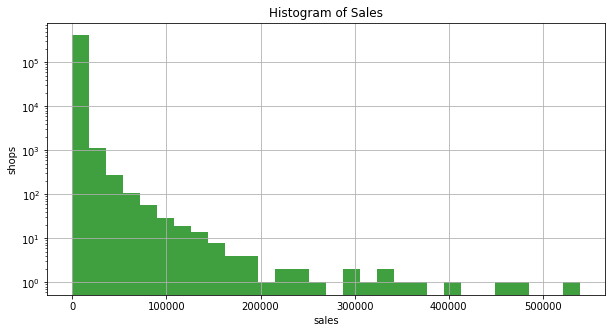

In [15]:
x = df['number_of_sales']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, 30, density=False, log=True, facecolor='g', alpha=0.75)
plt.xlabel('sales')
plt.ylabel('shops')
plt.title('Histogram of Sales')
plt.grid(True)
plt.show()


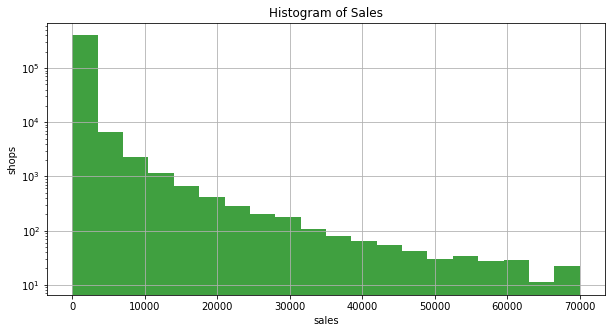

In [16]:
x = df['number_of_sales']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, 20, range=(0, 70000), density=False, log=True, facecolor='g', alpha=0.75)
plt.xlabel('sales')
plt.ylabel('shops')
plt.title('Histogram of Sales')
plt.grid(True)
plt.show()


In [17]:
n, bins

(array([4.01603e+05, 6.58100e+03, 2.29300e+03, 1.17200e+03, 6.74000e+02,
        4.15000e+02, 2.78000e+02, 2.05000e+02, 1.75000e+02, 1.09000e+02,
        7.90000e+01, 6.50000e+01, 5.50000e+01, 4.20000e+01, 3.00000e+01,
        3.40000e+01, 2.70000e+01, 2.80000e+01, 1.10000e+01, 2.20000e+01]),
 array([    0.,  3500.,  7000., 10500., 14000., 17500., 21000., 24500.,
        28000., 31500., 35000., 38500., 42000., 45500., 49000., 52500.,
        56000., 59500., 63000., 66500., 70000.]))

In [18]:
bins[32:34]

array([], dtype=float64)

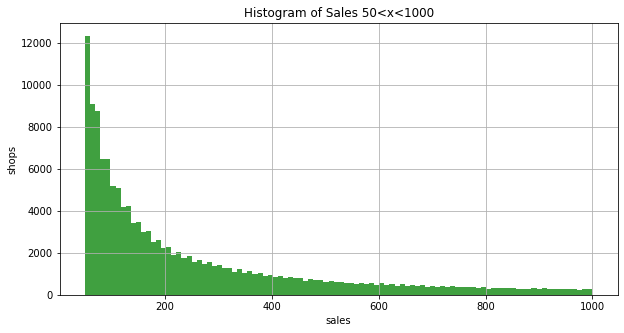

In [19]:
x = df['number_of_sales']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, 100, range=(50, 1000), density=False, log=False, facecolor='g', alpha=0.75)
plt.xlabel('sales')
plt.ylabel('shops')
plt.title('Histogram of Sales 50<x<1000')
plt.grid(True)
plt.show()


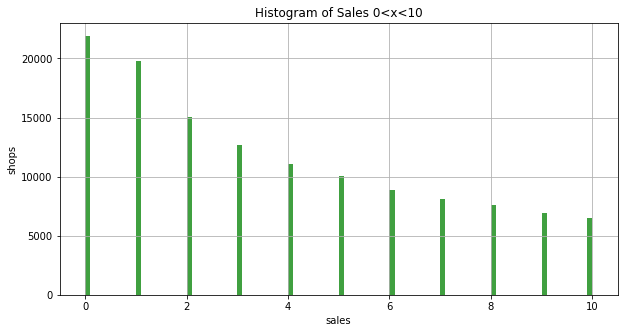

In [20]:
x = df['number_of_sales']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, 100, range=(0, 10), density=False, log=False, facecolor='g', alpha=0.75)
plt.xlabel('sales')
plt.ylabel('shops')
plt.title('Histogram of Sales 0<x<10')
plt.grid(True)
plt.show()


In [21]:
def get_pareto(N, number_of_sales):
    all_sales = number_of_sales.sum()
    all_shops = len(number_of_sales)
    NSales = number_of_sales.sort_values(ascending=True).tail(n=N).sum()
    return N / all_shops, NSales / all_sales

number_of_sales = df['number_of_sales']
get_pareto(1000, number_of_sales), get_pareto(10000, number_of_sales), get_pareto(100000, number_of_sales)

((0.0024151322526421545, 0.23012444449893427),
 (0.024151322526421548, 0.5922244124934236),
 (0.24151322526421548, 0.952246424872103))

### Interpreations for number_of_sales
* number of sales looks like classical Pareto-like "pyramide to climb" where only few people get to the top and have majority of sales: 13% have 94% percent of sales, 1.3% have 58% of sales, and majority do have just 0 or 1 sell
* starting about 200k sales there are "outlier space" - there are just few people in each hist bin are represented
* number of people with 0 and 1 sales are quite similar, and drastically goes down starting 2. Probably those with 0 and 1 are the same class, with people just asking their friends to buy something from them just to see how buying/selling works?

## number_of_reviews


In [22]:
df['number_of_reviews'].describe()

count    343125.000000
mean        146.683783
std        1065.174816
min           1.000000
25%           4.000000
50%          13.000000
75%          57.000000
max      184489.000000
Name: number_of_reviews, dtype: float64

/Users/aturkin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/Users/aturkin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



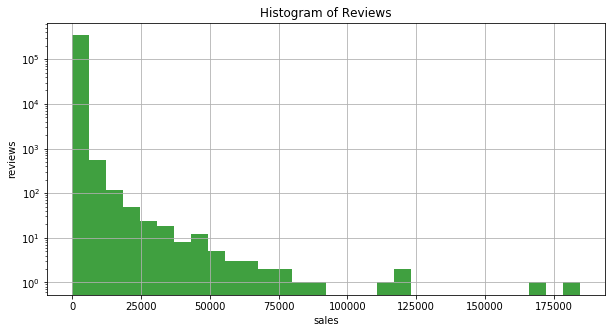

In [23]:
x = df['number_of_reviews']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, 30, density=False, log=True, facecolor='g', alpha=0.75)
plt.xlabel('sales')
plt.ylabel('reviews')
plt.title('Histogram of Reviews')
plt.grid(True)
plt.show()


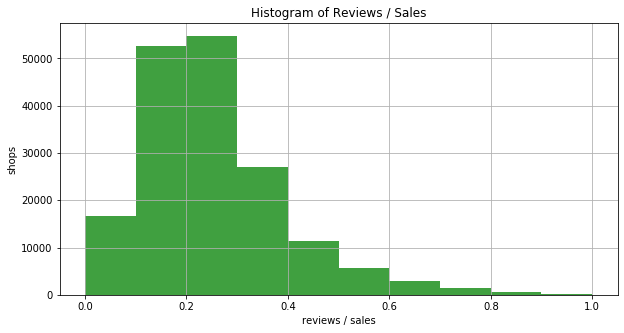

In [24]:
active_shops = df[ (df['number_of_sales'] > 50)]
# df['reviews_per_sales'] = df['number_of_reviews'] / df['number_of_sales']
x = active_shops['number_of_reviews'] / active_shops['number_of_sales']

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(x, range=(0,1), log=False, facecolor='g', alpha=0.75)
plt.xlabel('reviews / sales')
plt.ylabel('shops')
plt.title('Histogram of Reviews / Sales')
plt.grid(True)
plt.show()

In [25]:
x.describe()

count    173324.000000
mean          0.252339
std           0.140303
min           0.000884
25%           0.157500
50%           0.227273
75%           0.315971
max           1.351852
dtype: float64

In [26]:
corrmat = df[ ['number_of_sales', 'number_of_reviews']].corr()
corrmat

number_of_sales  number_of_reviews
number_of_sales           1.000000           0.909423
number_of_reviews         0.909423           1.000000

### Interpreations for number_of_reviews
* Number of reviews are highly correlated (coefficient is 0.9), which makes sense, as usually someone buys and then 
* Therefore, number of reviews also form Pareto distribution, being sort of shadow from the number of sales
* If we look at the ratio of reviews/sales, then we can see that it's normal distribution with ratio 0.3 being prevalent, and 25% is the mean value for a chance to get a review!
* Some shops actually have this ratio > 0.5, I wonder how do they achieve it?
* Some shops also have this ratio > 1, howerver the number of them is negligible. Does this mean that not much of people are regular visitors of the same shops, or maybe they do not tend to leave another review?

## average_review_score


In [27]:
df['average_review_score'].describe()

count    210095.000000
mean          4.897582
std           0.385392
min           1.000000
25%           4.954200
50%           5.000000
75%           5.000000
max           5.000000
Name: average_review_score, dtype: float64

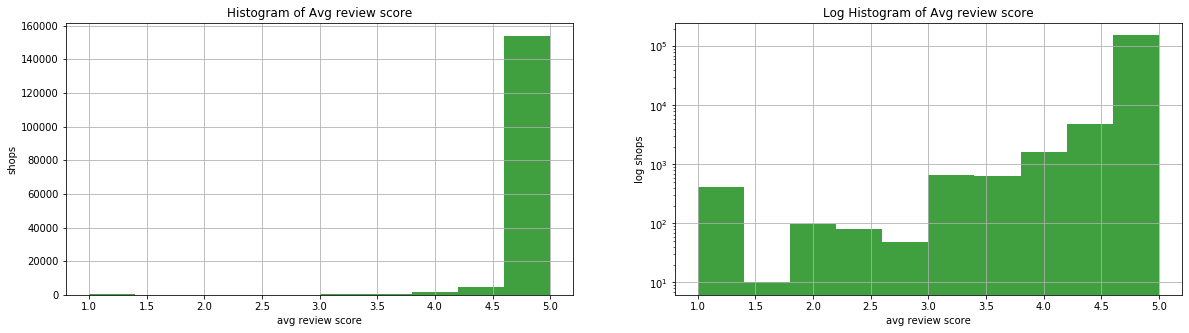

In [28]:
x = df[ (df['number_of_sales'] > 20)]['average_review_score']

plt.figure(figsize=(20, 5))
plt.subplot(121)
n, bins, patches = plt.hist(x, log=False, facecolor='g', alpha=0.75)
plt.xlabel('avg review score')
plt.ylabel('shops')
plt.title('Histogram of Avg review score')
plt.grid(True)

plt.subplot(122)
n, bins, patches = plt.hist(x, log=True, facecolor='g', alpha=0.75)
plt.xlabel('avg review score')
plt.ylabel('log shops')
plt.title('Log Histogram of Avg review score')
plt.grid(True)



plt.show()

### Interpretations for average_review_score
* I expected something of normal distribution, but majority of shops have it 5
* there is intersting gap between 1.0 and 2.0 : it looks like customers tend to use it not as scalar, but sort of sign "my experience was terribly wrong", so it gravitates towards lower end in this case. It makes sense: if you are frustrated customer, you won't be picking between 1 and 2, you set solid 1 in such case ;)
* so it looks like that customer use it without actually comparing shops to each other, but rather like something that shows their general experience with such shop
* probably, (however it is not 100% proven by this data) rewiew score seems to be used more like either binary classification - 5 if evertything is alright, and 1 if something was terribly wrong, so average score between 2 and 4 is a result of most people putting 5s, and some people putting 1s when there was delivery issue or another issues


## number of items

In [29]:
df['number_of_items'].describe(percentiles=[.25, .5, .75, .9, .95])

count    414056.000000
mean         45.344019
std         231.311105
min           0.000000
25%           0.000000
50%           6.000000
75%          31.000000
90%          99.000000
95%         190.000000
max       78611.000000
Name: number_of_items, dtype: float64

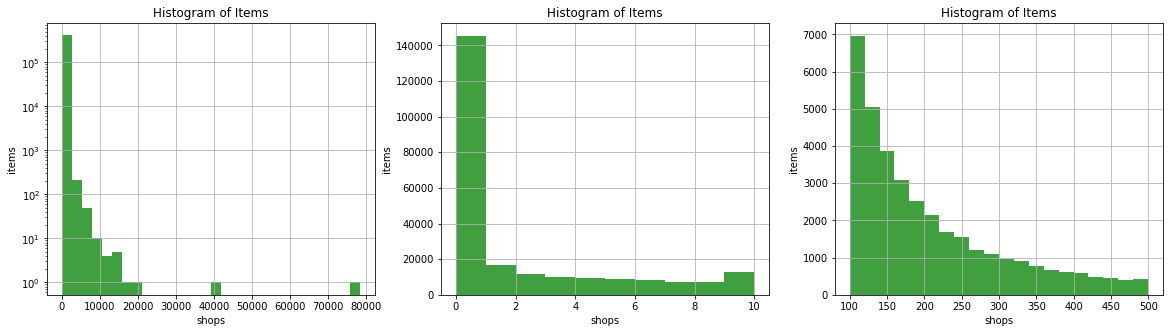

In [30]:
x = df['number_of_items']

plt.figure(figsize=(20, 5))
plt.subplot(131)
n, bins, patches = plt.hist(x, 30, density=False, log=True, facecolor='g', alpha=0.75)
plt.xlabel('shops')
plt.ylabel('items')
plt.title('Histogram of Items')
plt.grid(True)


plt.subplot(132)
n, bins, patches = plt.hist(x, 10, range = (0, 10), density=False, log=False, facecolor='g', alpha=0.75)
plt.xlabel('shops')
plt.ylabel('items')
plt.title('Histogram of Items')
plt.grid(True)

plt.subplot(133)
n, bins, patches = plt.hist(x, 20, range = (100, 500), density=False, log=False, facecolor='g', alpha=0.75)
plt.xlabel('shops')
plt.ylabel('items')
plt.title('Histogram of Items')
plt.grid(True)

plt.show()

In [31]:
corrmat = df[ ['number_of_sales', 'number_of_items']].corr()
corrmat

number_of_sales  number_of_items
number_of_sales         1.000000         0.347574
number_of_items         0.347574         1.000000

### Interpreations for number_of_items
* This is interesting - I would expect number of items to have normal distribution, but apparently it's another Pareto. 
* However, it's not like with number of reviews, as correlation is positive, but comparably low (0.35)
* Intersting drop between 0 and 1 items - so actually putting some item is a pretty much threshold (which makes sense, as cost of creating shop is low, but putting some item, requries this item at least)
* Probably what would explain Pareto distribution here, is that there is positive feedback loop: the more succesfull you're on etsy => the more items you want to put there => some of it brings your more success => loop continues
* 95 percentile is 114 items, not many actually do this threshold apparently

# Multivariative Analysis

In [32]:
df['sales_per_year'] = df['number_of_sales'] / (2019 + 1 - df['seller_join_date'])
df['reviews_per_year'] = df['number_of_reviews'] / (2019 + 1 - df['seller_join_date'])
df.head()

seller_location  seller_join_date  number_of_sales  \
0            Jaipur, India              2018                0   
1                      NaN              2017              226   
2  Soorts-Hossegor, France              2017               14   
3                      NaN              2019                0   
4                      NaN              2019                0   

   number_of_reviews  average_review_score  number_of_items      seller_town  \
0                NaN                   NaN                2           Jaipur   
1               12.0                   5.0                3              NaN   
2                2.0                   4.0                0  Soorts-Hossegor   
3                NaN                   NaN                2              NaN   
4                NaN                   NaN                9              NaN   

  seller_country  sales_per_year  reviews_per_year  
0          India        0.000000               NaN  
1            NaN       75.333333          4.000000  
2         France        4.666667          0.666667  
3            NaN        0.000000               NaN  
4            NaN        0.000000               NaN

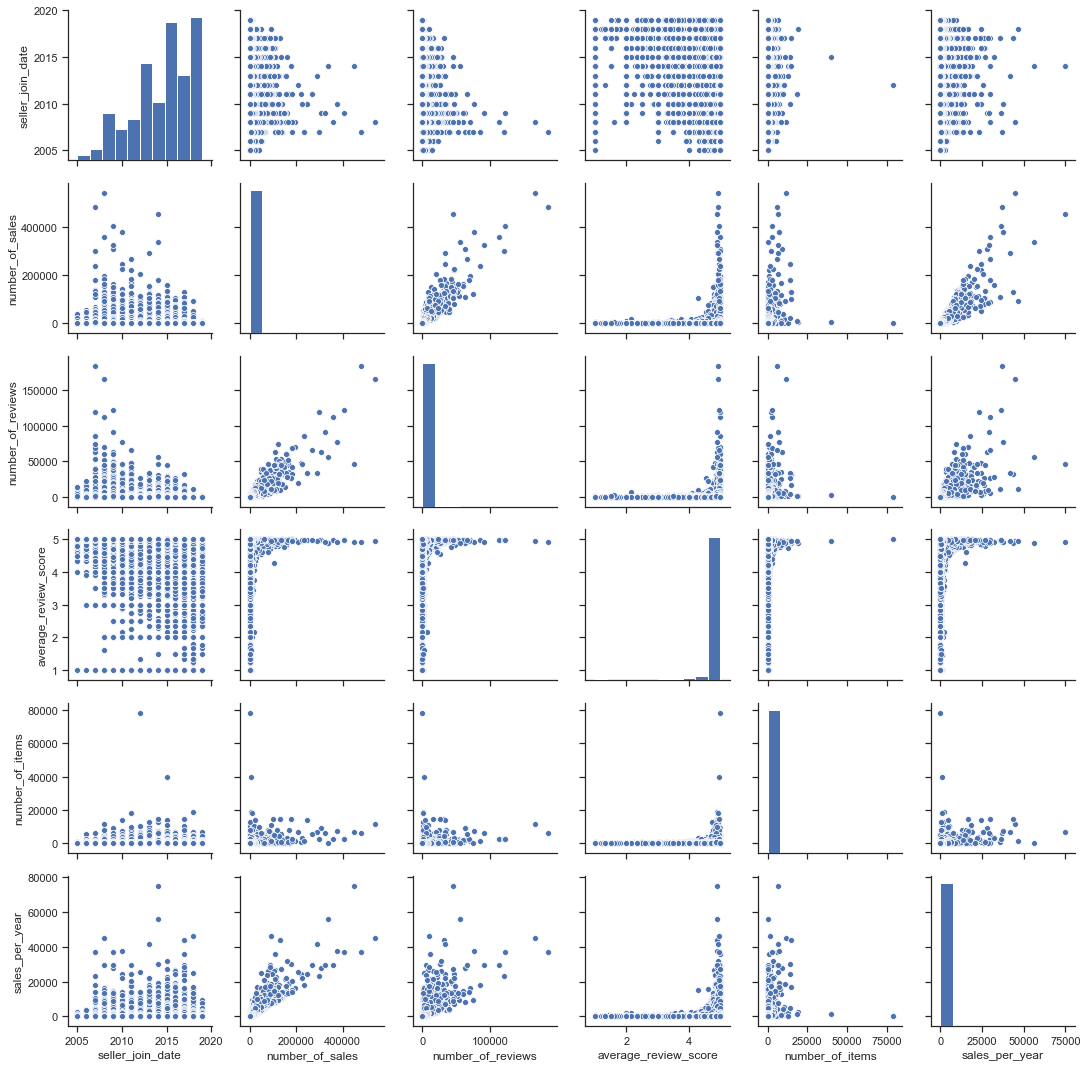

In [33]:
sns.set(style="ticks", color_codes=True)
cols = ['seller_join_date', 'number_of_sales', 'number_of_reviews', 'average_review_score', 'number_of_items', 'sales_per_year']
sns.pairplot(df[cols])

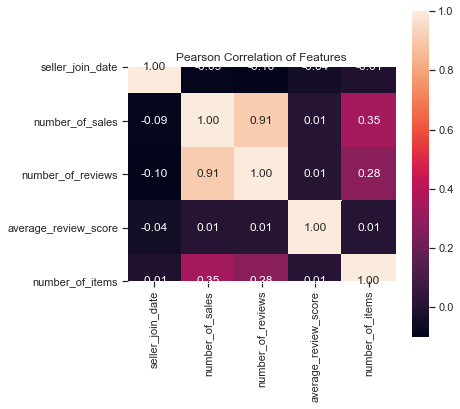

In [34]:
# cols = ['seller_join_date', 'number_of_sales', 'number_of_reviews', 'average_review_score', 'number_of_items', 'sales_per_year', 'reviews_per_year']
cols = ['seller_join_date', 'number_of_sales', 'number_of_reviews', 'average_review_score', 'number_of_items']

corrmat = df[cols].corr()
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, annot=True, square=True, fmt='.2f',   annot_kws={'fontsize':12 });
plt.title('Pearson Correlation of Features')
plt.show()


## Pairplot & Correlation matrix interpretation
* number of sales & number of reviews have strong correlation (**0.91**!): based on previous research, it looks like that number of reviews is about 30% of number of sales
* number of sales positevly correlates with number of items (**0.35**) - possibly, it's because the more sales you get, the more items you do
* surprisingly, number of sales is not correlated with date joined - it's (**-0.08**) - so being in business for a long time does not predict sales success. The same for number of reviews (also **-0.08**) and number of items (**-0.02**). Resolution: no matter when you've started, you can be good at sales!
* also, number of reviews do not correlate with avg review score - apparently, more reviews != bettter score. 
* and, average review score & seller join date are not much correlated - so no matter, when you've started, you can achieve good review score :) 
* It also looks like that bigger number of items does not mean more sales. You can have average amount of items, but which are well sold 
* It looks like pairplot would be more clear, if outliers would be deleted. This example shows us how to make it right!

# A bit of geography

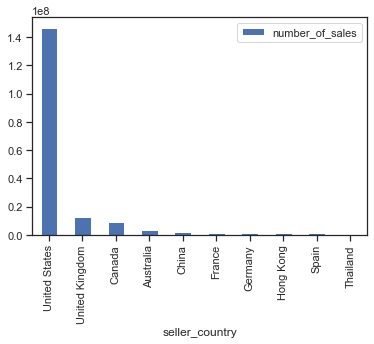

In [35]:
sales_by_country = locations[['number_of_sales', 'seller_country']].groupby(by='seller_country').sum().sort_values(by='number_of_sales', ascending=False)
sales_by_country = sales_by_country[ sales_by_country['number_of_sales'] > 0 ]
sales_by_country['number_of_sales_log'] = np.log(sales_by_country['number_of_sales'])
sales_by_country[['number_of_sales']].head(n=10).plot.bar()


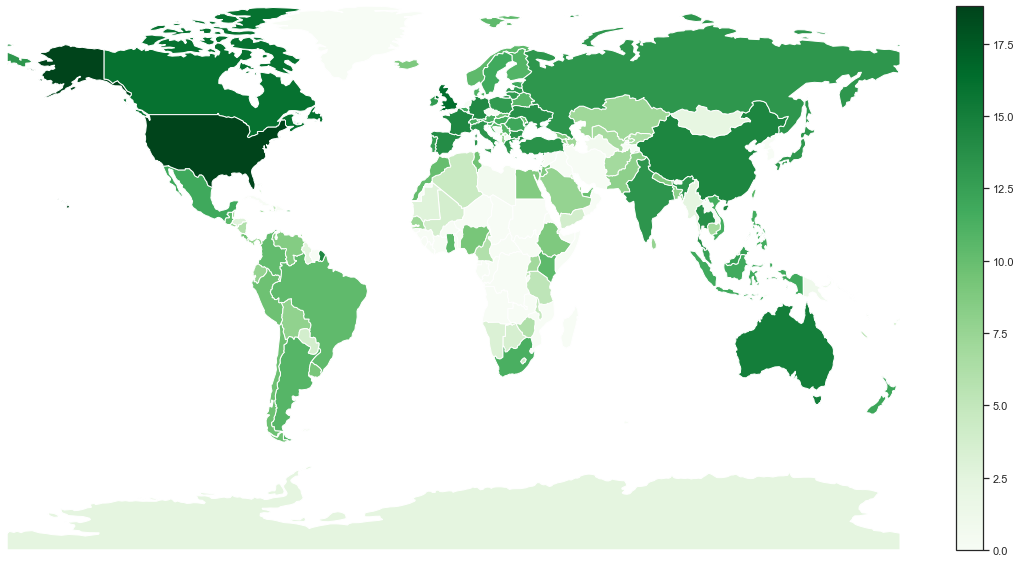

In [36]:
# countries that sell (c)
sales_by_country_geo = countries_geocodes.set_index('name').join(sales_by_country, how='left').reset_index()
geoplot.choropleth(sales_by_country_geo, hue='number_of_sales_log', cmap='Greens', k = None,legend=True, figsize=(20, 10))

In [37]:
all_locations_df = pd.read_csv("datasets/all_locations.csv")

sales_by_location = df[ ['seller_location', 'number_of_sales', 'seller_country', 'seller_town']].groupby(by=['seller_location', 'seller_country', 'seller_town']).sum().sort_values(by='number_of_sales', ascending=False)
sales_by_location = sales_by_location[ sales_by_location['number_of_sales'] > 0 ]
sales_by_location['number_of_sales_log'] = np.log(sales_by_location['number_of_sales'])
sales_by_location.head()



number_of_sales  \
seller_location           seller_country seller_town                    
California, United States United States  California          21370105   
Texas, United States      United States  Texas               10919979   
Florida, United States    United States  Florida             10847818   
New York, United States   United States  New York             7413647   
Washington, United States United States  Washington           5591231   

                                                      number_of_sales_log  
seller_location           seller_country seller_town                       
California, United States United States  California             16.877504  
Texas, United States      United States  Texas                  16.206105  
Florida, United States    United States  Florida                16.199475  
New York, United States   United States  New York               15.818833  
Washington, United States United States  Washington             15.536710

In [38]:
sales_by_location_geo = sales_by_location.reset_index().set_index('seller_location').join(all_locations_df.set_index('seller_location'), how='inner').reset_index()
sales_by_location_geo.head()


seller_location seller_country seller_town  number_of_sales  \
0    Aalborg, Denmark        Denmark     Aalborg             1324   
1  Aarau, Switzerland    Switzerland       Aarau               64   
2  Aarau, Switzerland    Switzerland       Aarau               64   
3      Abakan, Russia         Russia      Abakan              114   
4       Abaza, Russia         Russia       Abaza                1   

   number_of_sales_log      lng      lat  
0             7.188413   9.9166  57.0337  
1             4.158883   8.0524  47.3896  
2             4.158883   8.0340  47.3900  
3             4.736198  91.4450  53.7037  
4             0.000000  90.0954  52.6690

In [39]:
fig2 = px.scatter_geo(sales_by_location_geo, lat = 'lat', lon = 'lng',
                     size='number_of_sales',text='seller_location', hover_name='seller_location',
                     projection='natural earth', title='Sales by Location')
fig2.show()

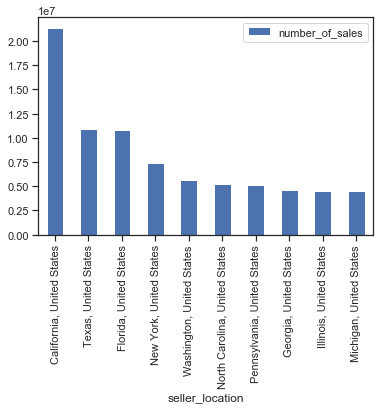

In [40]:
sales_by_location_geo.sort_values(by='number_of_sales', ascending=False).head(n=10).plot.bar(x='seller_location', y='number_of_sales')

In [41]:
fig2 = px.scatter_geo(sales_by_location_geo, lat = 'lat', lon = 'lng',
                     size='number_of_sales_log',text='seller_location', hover_name='seller_location',
                     projection='natural earth', title='Sales by Location - log scale')
fig2.show()

In [42]:
import plotly.express as px

filtered = sales_by_location_geo[(sales_by_location_geo['seller_country'] != 'United States')]

fig2 = px.scatter_geo(filtered, lat = 'lat', lon = 'lng',
                     size='number_of_sales',text='seller_location', hover_name='seller_location',
                     projection='natural earth', title = 'Sales by location, filtered')
fig2.show()

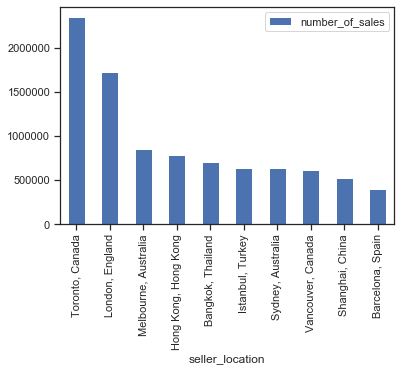

In [43]:
filtered.sort_values(by='number_of_sales', ascending=False).head(n=10).plot.bar(x='seller_location', y='number_of_sales')